In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import h5py
from sklearn.preprocessing import StandardScaler

#tf.config.optimizer.set_jit(False)

#Only for debugging, turn it to false after
#tf.config.run_functions_eagerly(True)

2025-10-29 04:33:08.322616: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 04:33:11.976949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-29 04:33:27.828510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
file_path = "/eos/user/s/ssaha/SWAN_projects/AD_Trigger_1/ntuples/lam_output/lam_test/EB_482596.h5"
# check any pre-existing cuts 

with h5py.File(file_path, "r") as f:
    datasets = {k: np.array(f[k]) for k in f}
    Ofl_data = datasets["Offline_data"]
    HLT_data = datasets["HLT_data"]
    #.reshape(-1, 45)
    weights = datasets["weights"] 
output_file = '/eos/user/s/ssaha/SWAN_projects/AD_Trigger_1/output_files_DisCo/ad_scores_noDisCo.h5'
output_file_ = '/eos/user/s/ssaha/SWAN_projects/AD_Trigger_1/mse_scores_offline_test.h5'

with h5py.File(output_file, 'r') as f:
    group = f['EB_test']
    HLT_AD_scores = group['HLT_AD_scores'][:].astype(np.float32) 
    #Offline_AD_scores = group['Offline_AD_scores'][:].astype(np.float32)

with h5py.File(output_file_, 'r') as f_:
    print("Top-level keys:", list(f_.keys()))
    Offline_AD_scores = f_['offline_AD_score'][:].astype(np.float32)

HLT_0 = np.sum(HLT_AD_scores==0)
print("zeroes HLT", HLT_0)
Ofl_0 = np.sum(Offline_AD_scores==0)
print("zeroes Offline", Ofl_0)
print(HLT_AD_scores.size)

n = min(len(HLT_AD_scores), len(Offline_AD_scores))
HLT_AD_scores_ = HLT_AD_scores[:n]
Offline_AD_scores_ = Offline_AD_scores[:n]

import matplotlib.pyplot as plt

# Plot: HLT vs Offline scores
'''plt.figure(figsize=(10, 6))
plt.scatter(HLT_AD_scores_, Offline_AD_scores_, alpha=0.2, s=10, label="HLT vs Offline (sampled)")
plt.xlabel("HLT Anomaly Score")
plt.ylabel("Offline Anomaly Score")
plt.title(f"HLT vs Offline Anomaly Score ({len(hlt_sample):,} Events)")
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.ylim(0, 5)
plt.tight_layout()
plt.show()
'''

Top-level keys: ['offline_AD_score']
zeroes HLT 595794
zeroes Offline 0
1048336


'plt.figure(figsize=(10, 6))\nplt.scatter(HLT_AD_scores_, Offline_AD_scores_, alpha=0.2, s=10, label="HLT vs Offline (sampled)")\nplt.xlabel("HLT Anomaly Score")\nplt.ylabel("Offline Anomaly Score")\nplt.title(f"HLT vs Offline Anomaly Score ({len(hlt_sample):,} Events)")\nplt.legend()\nplt.grid(True)\nplt.xlim(0, 10)\nplt.ylim(0, 5)\nplt.tight_layout()\nplt.show()\n'

(1048336, 16, 3)


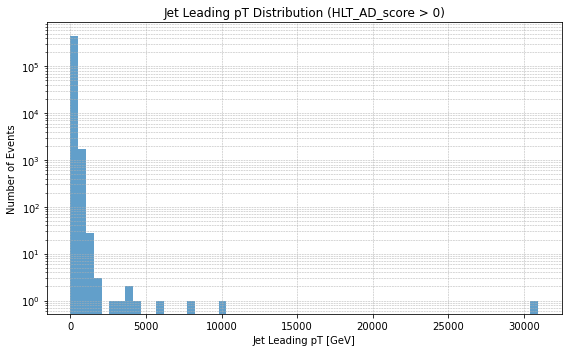

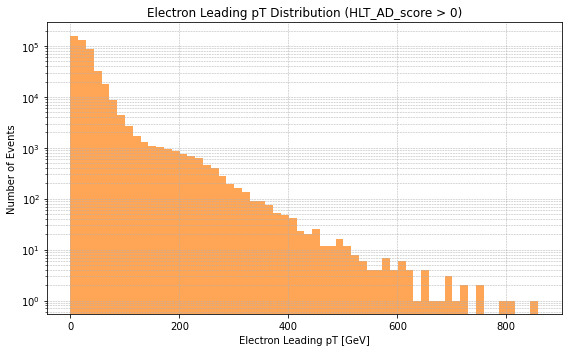

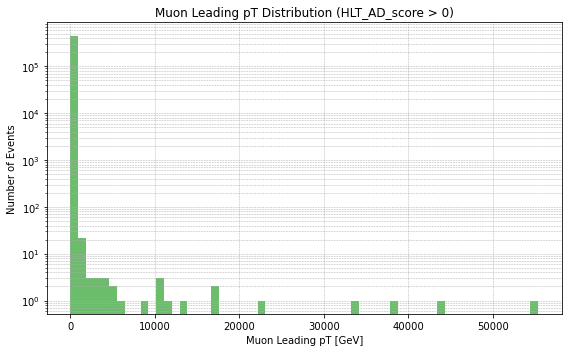

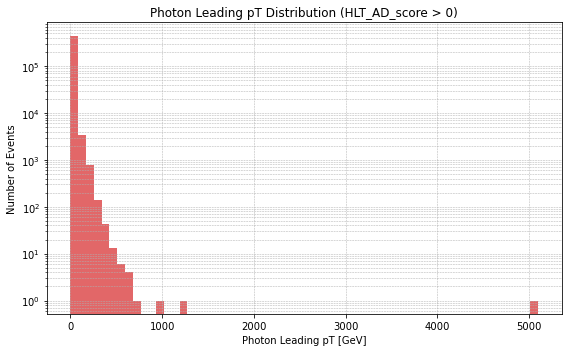

In [9]:
#plot HLT = 0 kinematics
weights=datasets["weights"]
mask = HLT_AD_scores>0
weights_ = weights[mask]

print(HLT_data.shape)
# Extract the leading (0th) pT for each object based on flattened index mapping
jet_pt_hlt = HLT_data[:, 0, 0]        # index 0 → (0, 0)
electron_pt_hlt = HLT_data[:, 6, 0]   # index 18 → (6, 0)
muon_pt_hlt = HLT_data[:, 9, 0]       # index 27 → (9, 0)
photon_pt_hlt = HLT_data[:, 14, 0]    # index 42 → (14, 0)

j_pt_hlt_0 = jet_pt_hlt[mask]
e_pt_hlt_0 = electron_pt_hlt[mask]
m_pt_hlt_0 = muon_pt_hlt[mask]
p_pt_hlt_0 = photon_pt_hlt[mask]

def plot_log_hist(data, label, color):
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=60, alpha=0.7, color=color, histtype='stepfilled')
    plt.xlabel(f"{label} Leading pT [GeV]")
    plt.ylabel("Number of Events")
    plt.title(f"{label} Leading pT Distribution (HLT_AD_score > 0)")
    plt.yscale("log")
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()

# --- Individual plots ---
plot_log_hist(j_pt_hlt_0, "Jet", "C0")
plot_log_hist(e_pt_hlt_0, "Electron", "C1")
plot_log_hist(m_pt_hlt_0, "Muon", "C2")
plot_log_hist(p_pt_hlt_0, "Photon", "C3")

In [14]:
from scipy.stats import pearsonr
r, p = pearsonr(HLT_AD_scores_, Offline_AD_scores_)
print("Pearson r:", r, "p-value:", p)

from scipy.stats import spearmanr
rho, p = spearmanr(HLT_AD_scores_, Offline_AD_scores_)
print("Spearman rho:", rho, "p-value:", p)

from scipy.stats import kendalltau
tau, p = kendalltau(HLT_AD_scores_, Offline_AD_scores_)
print("Kendall tau:", tau, "p-value:", p)

from sklearn.feature_selection import mutual_info_regression
import numpy as np

X = HLT_AD_scores_.reshape(-1, 1)  # needs 2D
Y = Offline_AD_scores_
mi = mutual_info_regression(X, Y, discrete_features=False)
print("Mutual Information:", mi[0])

#Results 
#Pearson r: 6.918867823525213e-06 p-value: 0.99434775 --> No linear 
#Spearman rho: 0.8233898695358459 p-value: 0.0 --> Monotonic 
#Kendall tau: 0.7358058521758124 p-value: 0.0 --> Monotonic
#Mutual Information: 0.667936666658763 --> Strong stat dependence, non linear origin, as Pearson is ~0


Pearson r: -9.595696e-06 p-value: 0.9969639512810908
Spearman rho: 0.0017400663779641463 p-value: 0.490183887034079
Kendall tau: 0.0012809557243604996 p-value: 0.49049519236636674
Mutual Information: 0


In [16]:
import numpy as np

def distance_corr(x, y, sample_size=100000, random_state=0):
    rng = np.random.default_rng(random_state)
    n = len(x)
    if sample_size < n:
        idx = rng.choice(n, sample_size, replace=False)
        x = x[idx]
        y = y[idx]
    # Distance matrices
    a = np.abs(x[:, None] - x[None, :])
    b = np.abs(y[:, None] - y[None, :])
    # Double centering
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    # Distance covariance/variance
    dcov = np.sqrt((A * B).mean())
    dvar_x = np.sqrt((A * A).mean())
    dvar_y = np.sqrt((B * B).mean())
    return 0 if dvar_x * dvar_y == 0 else dcov / np.sqrt(dvar_x * dvar_y)

dcorr_val = distance_corr(HLT_AD_scores_, Offline_AD_scores_, sample_size=5000)
print("Distance correlation (approx):", dcorr_val)

def distance_corr_normalized_log(x, y, sample_size=100000, random_state=0):
    x = np.log1p(x)
    y = np.log1p(y)
    scaler = StandardScaler()
    x = scaler.fit_transform(x.reshape(-1,1)).ravel()
    y = scaler.fit_transform(y.reshape(-1,1)).ravel()
    
    return distance_corr(x, y, sample_size, random_state)

dcorr_norm_log = distance_corr_normalized_log(HLT_AD_scores_, Offline_AD_scores_, sample_size=10000)
print("Normalized distance correlation (log scale, approx):", dcorr_norm_log)

Distance correlation (approx): 0.027186481
Normalized distance correlation (log scale, approx): 0.013149054


In [17]:
#pT Normalization - huge pT ranges for some events, messes up the training! 

class NormalizepT(tf.keras.layers.Layer): #base layer class
    def __init__(self, scale_factor, **kwargs): #constructor, set up initial state 
        super().__init__(**kwargs) #calls the above constructor to initialze the arguments properly 
        self.scale_factor = scale_factor
        
    def call(self, data): #(N, 15, 3) for offline data
        data_scaled = tf.concat([tf.expand_dims(data[:,:,0]* self.scale_factor, axis = -1), data[:,:,1:]],axis = -1)
        #print("data_scaled",data_scaled)
        return data_scaled

Ofl_tensor = tf.convert_to_tensor(Ofl_data, dtype=tf.float32)
norm_layer = NormalizepT(scale_factor=0.005)
Ofl_norm = norm_layer(Ofl_tensor)

Ofl_pTnorm = tf.reshape(Ofl_norm, (-1,45))
Ofl_pTnorm = Ofl_pTnorm.numpy()
#print("ofl_flat", Ofl_pTnorm, Ofl_pTnorm.shape)
#print("ofl_data", Ofl_data, Ofl_data.shape)
print(np.max(Ofl_pTnorm))
print(np.max(Ofl_data))

I0000 00:00:1761615148.676957     345 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:07.0, compute capability: 7.5


14729.141
2945828.25


In [18]:
def safe_log1p_clip(t, min_val=0.0, max_val=1e20):
    t = tf.clip_by_value(t, min_val, max_val)
    return tf.math.log1p(t)

def disco_loss(y_true, y_pred, lambda_disco=10.0, threshold=1e20, eps=1e-12, clip_val=1e6):
    
    X_true = y_true[:, :-1]
    hlt_batch = y_true[:, -1]
    
    #MSE score
    offline_AD_score = tf.reduce_mean(tf.square(X_true - y_pred), axis=-1)
    
    offline_AD_score_col = tf.reshape(offline_AD_score, [-1, 1])
    hlt_col = tf.reshape(hlt_batch, [-1, 1])
    
    #pairwise differences
    diff_off = offline_AD_score_col[:, None] - offline_AD_score_col[None, :]
    diff_hlt = hlt_col[:, None] - hlt_col[None, :]

    eps_norm = 1e-12
    norm_off = tf.sqrt(tf.reduce_sum(diff_off**2, axis=-1) + eps_norm)
    norm_hlt = tf.sqrt(tf.reduce_sum(diff_hlt**2, axis=-1) + eps_norm)

    a = norm_off
    b = norm_hlt

    A = a - tf.reduce_mean(a, axis=0) - tf.reduce_mean(a, axis=1)[:, None] + tf.reduce_mean(a)
    B = b - tf.reduce_mean(b, axis=0) - tf.reduce_mean(b, axis=1)[:, None] + tf.reduce_mean(b)

    mAB = tf.reduce_mean(A * B)
    mAA = tf.reduce_mean(A * A)
    mBB = tf.reduce_mean(B * B)

    denom = tf.sqrt(mAA * mBB) + eps
    dcorr_sq = mAB / denom
    dcorr_sq = tf.clip_by_value(dcorr_sq, 0.0, 1.0)
    dcorr = tf.sqrt(dcorr_sq)
    total_loss = offline_AD_score + lambda_disco * dcorr

    return total_loss

In [19]:
# Create a large Autoencoder (encoder + decoder + AE model)
# ---------------------------------------------------------

def create_large_AE(input_dim, h_dim_1, h_dim_2, h_dim_3, h_dim_4, latent_dim, 
                    l2_reg=0.01, dropout_rate=0.0):
    
    #Not taking preprocessed output like here (for now) - https://github.com/max-cohen54/AD_trigger_training/blob/main/HLTAD/ensembler_functions.py#L768
    #input dim for offline is 45, no MET
    # ---------------- Encoder ----------------

    encoder_inputs = layers.Input(shape=(input_dim,))
    
    x = layers.Dense(h_dim_1, kernel_regularizer=regularizers.l2(l2_reg))(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(h_dim_2, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(h_dim_3, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(h_dim_4, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    z = layers.Dense(latent_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)
    z = layers.BatchNormalization()(z)
    z = layers.Activation('relu')(z)

    #clipping values?
    z = layers.Lambda(lambda t: tf.clip_by_value(t, -1e3, 1e3))(z)

    encoder = Model(inputs=encoder_inputs, outputs=z, name="encoder")

    # ---------------- Decoder ----------------
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_4, kernel_regularizer=regularizers.l2(l2_reg))(decoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)    

    x = layers.Dense(h_dim_3, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(h_dim_2, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(h_dim_1, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(input_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)

    decoder = Model(inputs=decoder_inputs, outputs=outputs, name="decoder")

    # ---------------- Autoencoder ----------------
    ae_inputs = layers.Input(shape=(input_dim,))
    
    # Forward pass with debug Lambda layers
    encoded = encoder(ae_inputs)
    decoded = decoder(encoded)
    
    ae = Model(ae_inputs, outputs=decoded, name="autoencoder")

    return ae, encoder, decoder
    
INPUT_DIM = 45 #No MET in Offline data yet
H_DIM_1 = 100
H_DIM_2 = 100
H_DIM_3 = 64
H_DIM_4 = 32
LATENT_DIM = 4
L2_reg_coupling = 0.0001
dropout_p = 0.1

ae, encoder, decoder = create_large_AE(INPUT_DIM, H_DIM_1, H_DIM_2, H_DIM_3, H_DIM_4,
                                       LATENT_DIM, l2_reg=L2_reg_coupling, dropout_rate=dropout_p)


ae_mse, encoder_mse, decoder_mse = create_large_AE(INPUT_DIM, H_DIM_1, H_DIM_2, H_DIM_3, H_DIM_4,
                                       LATENT_DIM, l2_reg=L2_reg_coupling, dropout_rate=dropout_p)

HLT_scores = HLT_AD_scores 
X = Ofl_pTnorm 

X_train, X_val, hlt_train, hlt_val = train_test_split(
    X, HLT_scores, test_size=0.15, random_state=0
)
# Pack X and HLT into y_train, y_val, give HLT score info for disco calc, dependent on the batch size
y_train = np.concatenate([X_train, hlt_train[:, None]], axis=1).astype(np.float32)
y_val   = np.concatenate([X_val, hlt_val[:, None]], axis=1).astype(np.float32)

print("Done!")

Done!


In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm = 1.0)

#No weights yet, add later
#run_eagerly set to true for debugging only, prints the loss values, turn to false after.

#ae = DebugAutoencoder(encoder, decoder)

ae.compile(
    optimizer=optimizer,
    loss=lambda y_true, y_pred: disco_loss(y_true, y_pred, lambda_disco=50.0),
    metrics=[],run_eagerly=True
)


#train_weights = 1000*datasets['EB_train']['weights']/np.sum(datasets['EB_train']['weights'])
#val_weights = 1000*datasets['EB_val']['weights']/np.sum(datasets['EB_val']['weights'])

history = ae.fit(
    X_train[:100000], y_train[:100000],
    validation_data=(X_val[:100000], y_val[:100000]),
    #sample_weight = train_weights,
    epochs=30,
    batch_size=512,
    verbose=2
)

ae.save("trained_model_log.keras")


optimizer_mse = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm = 1.0)

ae_mse.compile(
    optimizer=optimizer_mse,
    loss = "mse",
    metrics=[],run_eagerly=True
)
history_mse = ae_mse.fit(
    X_train[:100000], X_train[:100000],
    validation_data=(X_val[:100000], X_val[:100000]),
    epochs=30,
    batch_size=512,
    verbose=2
)

ae_mse.save("trained_model_mse.keras")


Epoch 1/30
196/196 - 103s - 524ms/step - loss: 11.8463 - val_loss: 18.0283
Epoch 2/30
196/196 - 99s - 507ms/step - loss: 8.2180 - val_loss: 15.3371
Epoch 3/30
196/196 - 98s - 498ms/step - loss: 7.6892 - val_loss: 12.8760
Epoch 4/30
196/196 - 99s - 503ms/step - loss: 7.4744 - val_loss: 11.5611
Epoch 5/30
196/196 - 99s - 503ms/step - loss: 7.2235 - val_loss: 11.7555
Epoch 6/30
196/196 - 99s - 503ms/step - loss: 7.1478 - val_loss: 10.9891
Epoch 7/30
196/196 - 97s - 495ms/step - loss: 7.0897 - val_loss: 10.7050
Epoch 8/30
196/196 - 100s - 512ms/step - loss: 7.0669 - val_loss: 11.2307
Epoch 9/30
196/196 - 99s - 504ms/step - loss: 6.9366 - val_loss: 10.3357
Epoch 10/30
196/196 - 98s - 499ms/step - loss: 6.9276 - val_loss: 10.4742
Epoch 11/30
196/196 - 98s - 501ms/step - loss: 6.9742 - val_loss: 9.8284
Epoch 12/30
196/196 - 99s - 505ms/step - loss: 6.9596 - val_loss: 10.0048
Epoch 13/30
196/196 - 142s - 723ms/step - loss: 6.9627 - val_loss: 9.4052
Epoch 14/30
196/196 - 98s - 499ms/step - loss

/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: disco_loss(y_true, y_pred, lambda_disco=50.0),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


Epoch 1/30
196/196 - 93s - 474ms/step - loss: 2.3028 - val_loss: 2.0184
Epoch 2/30
196/196 - 92s - 468ms/step - loss: 1.9912 - val_loss: 1.8945
Epoch 3/30
196/196 - 92s - 467ms/step - loss: 1.8836 - val_loss: 1.8347
Epoch 4/30
196/196 - 91s - 464ms/step - loss: 1.8247 - val_loss: 1.7973
Epoch 5/30
196/196 - 92s - 469ms/step - loss: 1.7842 - val_loss: 1.7673
Epoch 6/30
196/196 - 92s - 468ms/step - loss: 1.7507 - val_loss: 1.7378
Epoch 7/30
196/196 - 93s - 474ms/step - loss: 1.7198 - val_loss: 1.7087
Epoch 8/30
196/196 - 92s - 471ms/step - loss: 1.6904 - val_loss: 1.6795
Epoch 9/30
196/196 - 92s - 468ms/step - loss: 1.6615 - val_loss: 1.6508
Epoch 10/30
196/196 - 91s - 466ms/step - loss: 1.6354 - val_loss: 1.6265
Epoch 11/30
196/196 - 93s - 473ms/step - loss: 1.6124 - val_loss: 1.6048
Epoch 12/30
196/196 - 92s - 470ms/step - loss: 1.5903 - val_loss: 1.5835
Epoch 13/30
196/196 - 92s - 468ms/step - loss: 1.5703 - val_loss: 1.5649
Epoch 14/30
196/196 - 92s - 468ms/step - loss: 1.5522 - val_

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 104s 33ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 103s 33ms/step


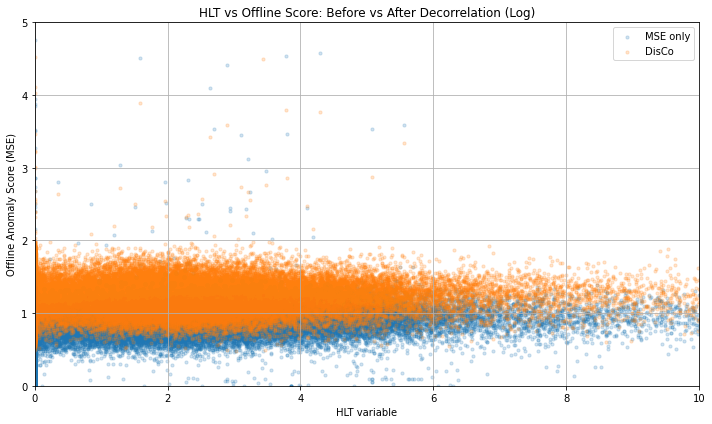

In [21]:
import matplotlib.pyplot as plt

# Get predictions
y_pred_mse = ae_mse.predict(X_val[:100000])
y_pred_decor = ae.predict(X_val[:100000])

# Extract HLT values from y_val (last column)
hlt = y_val[:100000, -1]

# Compute offline scores
score_mse = np.mean((X_val[:100000] - y_pred_mse) ** 2, axis=1)
score_decor = np.mean((y_val[:100000, :-1] - y_pred_decor) ** 2, axis=1)

# Plot
plt.figure(figsize=(10, 6))
#plt.scatter(hlt, score_mse, alpha=0.2, label="Before (MSE only)", s=10)
#plt.scatter(hlt, score_decor, alpha=0.2, label="After (DisCo decor)", s=10)
plt.scatter(hlt, np.log1p(score_mse), alpha=0.2, label="MSE only", s=10)
plt.scatter(hlt, np.log1p(score_decor), alpha=0.2, label="DisCo", s=10)

plt.xlabel("HLT variable")
plt.ylabel("Offline Anomaly Score (MSE)")
plt.title("HLT vs Offline Score: Before vs After Decorrelation (Log)")
plt.legend()
plt.grid(True)
plt.xlim(0,10)
plt.ylim(0,5)
plt.tight_layout()
plt.show()


In [23]:
from scipy.stats import spearmanr

rho_mse, _ = spearmanr(hlt, score_mse)
rho_disco, _ = spearmanr(hlt, score_decor)
print(f"Spearman: MSE={rho_mse:.4f}, DisCo={rho_disco:.4f}")


Spearman: MSE=0.3523, DisCo=0.0742


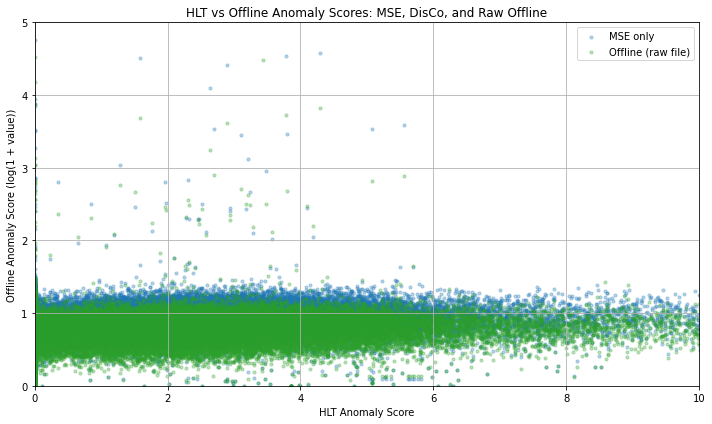

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# --- Align the offline HDF5 scores with your HLT arrays ---
n = min(len(hlt), len(Offline_AD_scores))
hlt = hlt[:n]
score_mse = score_mse[:n]
score_decor = score_decor[:n]
Offline_AD_scores = Offline_AD_scores[:n]

# --- Optional: subsample if very large ---
n_samples = 100_000
if n > n_samples:
    idx = np.random.choice(n, size=n_samples, replace=False)
    hlt_sample = hlt[idx]
    mse_sample = score_mse[idx]
    decor_sample = score_decor[idx]
    offline_sample = Offline_AD_scores[idx]
else:
    hlt_sample = hlt
    mse_sample = score_mse
    decor_sample = score_decor
    offline_sample = Offline_AD_scores

# --- Combined plot: same HLT, 3 different anomaly scores ---
plt.figure(figsize=(10, 6))

plt.scatter(hlt_sample, np.log1p(mse_sample),
            alpha=0.3, s=10, color='tab:blue', label='MSE only')

#plt.scatter(hlt_sample, np.log1p(decor_sample),
            #alpha=0.3, s=10, color='tab:orange', label='DisCo decorrelated')

plt.scatter(hlt_sample, np.log1p(offline_sample),
            alpha=0.3, s=10, color='tab:green', label='Offline (raw file)')

# --- Labels and style ---
plt.xlabel("HLT Anomaly Score")
plt.ylabel("Offline Anomaly Score (log(1 + value))")
plt.title("HLT vs Offline Anomaly Scores: MSE, DisCo, and Raw Offline")
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.ylim(0, 5)
plt.tight_layout()
plt.show()


In [ ]:
#HLT and Offline variables for 0 score HLT 